![](https://wherobots.com/wp-content/uploads/2023/12/Inline-Blue_Black_onWhite.png)
</br>
<div style="display: flex;justify-content: flex-end; align-items: center; max-width: 100%; margin: auto; gap: 90px;">
    <!-- Main Content Box -->
    <div style="position: relative; display: flex; flex-direction: column; gap: 30px; 
                font-family: Arial, sans-serif; line-height: 1.6; max-width: 800px; 
                padding: 30px; color: #ffffff; background: #121212; 
                border-radius: 10px; box-shadow: 0px 0px 20px rgba(0, 255, 255, 0.0); 
                overflow: hidden;">
        <!-- Introductory Text -->
        <div style="position: relative; z-index: 2;">
               <h2 style="color: #00f5d4;">WherobotsAI Raster Inference - Object Detection</h2>
            <p style="font-size: 18px; color: #e0e0e0;">
                This example demonstrates an object detection model 
                with <strong>Raster Inference</strong> to identify <span style="color: #00f5d4; font-weight: bold;">
                marine infrastructure</span> (offshore wind farms and platforms) in satellite imagery.
            </p>
            <p style="font-size: 18px; color: #e0e0e0;">
                We will use a <strong>machine-learning model</strong> from <span style="color: #ff007f; font-weight: bold;">
                Satlas</span>, which was trained using imagery from the 
                <strong>European Space Agency’s Sentinel-2 satellites</strong>.
            </p>
        </div>
    </div>
    <!-- Right Section: Icons -->
    <div style="display: flex; flex-direction: column; align-items: flex-end; gap: 20px">
        <img src="./img/offshore_oil.png" 
             alt="Setup Icon" 
             style="width: 100%; height: 100%; border-radius: 8px;margin: 20px">
        <img src="./img/wind_farm.png" 
             alt="Wind Engine Offshore" 
             style="width: 100%; height: 100%; border-radius: 8px;margin: 20px ">
    </div>

</div>

</br>


</br>
<div style="position: relative; display: flex; flex-direction: column; gap: 20px; 
            font-family: Arial, sans-serif; line-height: 1.6; max-width: 90%; 
            margin: auto; padding: 30px; color: #ffffff; background: #121212; 
            border-radius: 10px;); 
            overflow: hidden;">
    <!-- Title Section -->
    <div style="position: relative; z-index: 2; text-align: left;">
        <h2 style="color: #00f5d4;">Set Up The WherobotsDB Context</h2>
    </div>
    <!-- Main Content -->
    <div style="position: relative; z-index: 2;">
        <p style="font-size: 18px; color: #e0e0e0;">
            Here we configure WherobotsDB to enable access to the necessary cloud object storage buckets with sample data.
        </p>
    </div>
    <!-- Right Section: AI Icon -->
    <div style="display: flex; justify-content: flex-end; position: relative; z-index: 2; margin-top: 10px;">
    </div>
</div>
</br>

In [1]:
import warnings
warnings.filterwarnings('ignore')

from sedona.spark import SedonaContext
from pyspark.sql.functions import expr, size, col
from sedona.maps.SedonaKepler import SedonaKepler
from sedona.raster_utils.SedonaUtils import SedonaUtils
import json

config = SedonaContext.builder().appName('object-detection-batch-inference')\
    .getOrCreate()

sedona = SedonaContext.create(config)

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


</br>
<div style="position: relative; display: flex; flex-direction: column; gap: 20px; 
            font-family: Arial, sans-serif; line-height: 1.6; max-width: 90%; 
            margin: auto; padding: 30px; color: #ffffff; background: #121212; 
            border-radius: 10px;); 
            overflow: hidden;">
    <!-- Title Section -->
    <div style="position: relative; z-index: 2; text-align: left;">
        <h2 style="color: #00f5d4;">Load Satellite Imagery Efficiently</h2>
    </div>
    <!-- Main Content -->
    <div style="position: relative; z-index: 2;">
<p style="font-size: 18px; color: #e0e0e0;">
            In this step, we load the satellite imagery to run <strong style="color: #00f5d4;">inference</strong> over.  
            These <strong>GeoTIFF images</strong> are ingested as <strong style="color: #00f5d4;">out-of-database or "out-db" rasters</strong> in 
            <strong>WherobotsDB</strong> and stored in the Spatial Catalog for easy access. Building out DB ensuring efficient storage and retrieval. You can learn more about his process here.
        </p>
    </div>
    <!-- Right Section: AI Icon -->
    <div style="display: flex; justify-content: flex-end; position: relative; z-index: 2; margin-top: 10px;">
    </div>
</div>
</br>

In [2]:
df_raster_input = sedona.table(f"wherobots_pro_data.satlas.offshore_satlas")

In [3]:
df_raster_input.count()

176000

</br>
<div style="position: relative; display: flex; flex-direction: column; gap: 20px; 
            font-family: Arial, sans-serif; line-height: 1.6; max-width: 90%; 
            margin: auto; padding: 30px; color: #ffffff; background: #121212; 
            border-radius: 10px;); 
            overflow: hidden;">
    <!-- Title Section -->
    <div style="position: relative; z-index: 2; text-align: left;">
        <h2 style="color: #00f5d4;">Focus on a Coastal Region</h2>
    </div>
    <!-- Main Content -->
    <div style="position: relative; z-index: 2;">
        <p style="font-size: 18px; color: #e0e0e0;">
            With <strong>176,000 images</strong> covering most of Earth's coastlines, let's choose an area to focus on.
        </p>
        <p style="font-size: 18px; color: #e0e0e0;">
            Draw a <span style="color: #00f5d4; font-weight: bold;">polygon</span> around the <strong>Yellow Sea</strong> 
            off the east coast of China to define an area of interest (AOI).
        </p>
    </div>
    <!-- Right Section: AI Icon -->
    <div style="display: flex; justify-content: flex-end; position: relative; z-index: 2; margin-top: 10px;">
    </div>
</div>
</br>


In [4]:
from leafmap import Map

my_map = Map(zoom=7, center = (36.5, 122))
my_map

Map(center=[36.5, 122], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

In [5]:
if my_map.user_roi is None:
    my_map.user_roi = {'type': 'Feature',
                       'properties': {},
                       'geometry': {'type': 'Polygon',
                        'coordinates': [[[120.959473, 35.918528],
                                        [120.959473, 36.820829],
                                        [123.046875, 36.820829],
                                        [123.046875, 35.918528],
                                        [120.959473, 35.918528]]]}}

In [6]:
my_map.user_roi # this shows the last draw feature

{'type': 'Feature',
 'properties': {},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[120.959473, 35.918528],
    [120.959473, 36.820829],
    [123.046875, 36.820829],
    [123.046875, 35.918528],
    [120.959473, 35.918528]]]}}

In [7]:
feature_json = json.dumps(my_map.user_roi) # formats the python dictionary as a string so we can pass it to SQL
df_raster_sub = df_raster_input.where(
    expr(f"""ST_INTERSECTS(footprint, ST_GeomFromGeoJSON('{feature_json}'))""")
)

df_raster_sub.cache()
print(f"IMAGE COUNT: {df_raster_sub.count()}")
df_raster_sub.show(3, truncate=True)
df_raster_sub.createOrReplaceTempView("df_raster_input")
df_raster_sub.count()

IMAGE COUNT: 481
+--------------------+--------------------+-------------------+--------------------+
|        outdb_raster|                path|               name|           footprint|
+--------------------+--------------------+-------------------+--------------------+
|OutDbGridCoverage...|s3://wherobots-be...| 864697964-1-2.tiff|POLYGON ((120.871...|
|OutDbGridCoverage...|s3://wherobots-be...| 163816945-1-2.tiff|POLYGON ((120.871...|
|OutDbGridCoverage...|s3://wherobots-be...|2015411785-1-2.tiff|POLYGON ((120.871...|
+--------------------+--------------------+-------------------+--------------------+
only showing top 3 rows



481

</br>
<div style="position: relative; display: flex; flex-direction: column; gap: 20px; 
            font-family: Arial, sans-serif; line-height: 1.6; max-width: 90%; 
            margin: auto; padding: 30px; color: #ffffff; background: #121212; 
            border-radius: 10px; 
            overflow: hidden;">
    <!-- Main Content -->
    <div style="position: relative; z-index: 2;text-align: left;">
        <h2 style="color: #00f5d4;text-align: left;">Viewing Results</h2>
        <p style="font-size: 18px; color: #e0e0e0;">
           With our AOI defined we can see the footprints of the images in the area with the <code>SedonaKepler.create_map()</code> integration .
        </p>
        <p style="font-size: 18px; color: #e0e0e0;">
           Using <code>SedonaUtils.display_image()</code> we can view the images as well.
        </p>
    </div>
    </br>
    <!-- Right Section: Map Icon -->
    <div style="display: flex; justify-content: flex-end; position: relative; z-index: 2; margin-top: 10px;">

</div>
</br>

In [8]:
from sedona.maps.SedonaKepler import SedonaKepler

map = SedonaKepler.create_map()

SedonaKepler.add_df(map, df=df_raster_sub, name="Image Footprints")

map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Image Footprints': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18…


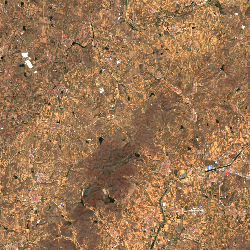
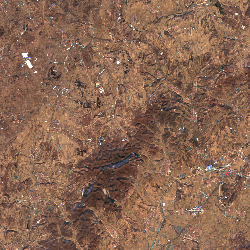
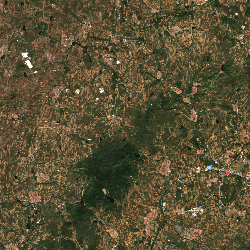
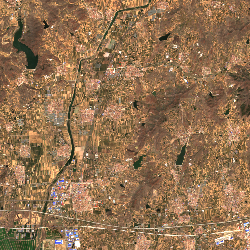
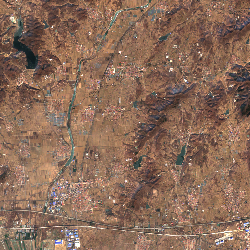
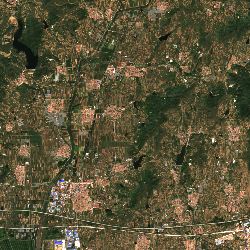
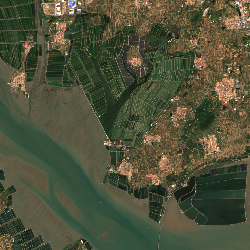
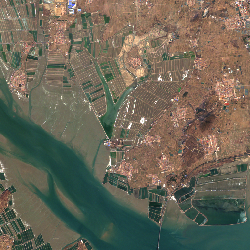
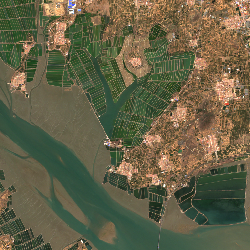
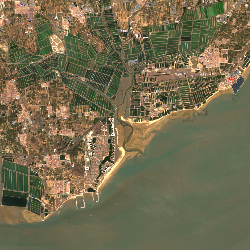

CPU times: user 38.4 ms, sys: 4.52 ms, total: 43 ms
Wall time: 6.72 s


In [9]:
%%time
htmlDf = sedona.sql(f"""SELECT RS_AsImage(outdb_raster, 250), name as FROM df_raster_input limit 10""")
SedonaUtils.display_image(htmlDf)

</br>
<div style="position: relative; display: flex; flex-direction: column; gap: 20px; 
            font-family: Arial, sans-serif; line-height: 1.6; max-width: 90%; 
            margin: auto; padding: 30px; color: #ffffff; background: #121212; 
            border-radius: 10px;); 
            overflow: hidden;">
    <!-- Title Section -->
    <div style="position: relative; z-index: 2; text-align: left;">
        <h2 style="color: #00f5d4;">Run Predictions And Visualize Results</h2>
    </div>
    <!-- Main Content -->
    <div style="position: relative; z-index: 2;">
        <p style="font-size: 18px; color: #e0e0e0;">
            To run predictions, we will specify the model we wish to use. Some models are pre-loaded and made available in 
            <strong>Wherobots Cloud</strong>. We can also load our own models. 
        </p>
        <p style="font-size: 18px; color: #e0e0e0;">
            Inference can be run using <strong>Wherobots' Spatial SQL functions</strong>, in this case: <code>RS_DETECT_BBOXES()</code>
        </p>
        <p style="font-size: 18px; color: #e0e0e0;">
            Here we generate predictions for all images in the AOI.
        </p>
    </div>
    <!-- Right Section: AI Icon -->
    <div style="display: flex; justify-content: flex-end; position: relative; z-index: 2; margin-top: 10px;">
    </div>
</div>
</br>

In [10]:
model_id = 'marine-satlas-sentinel2'

predictions_df = sedona.sql(f"""
SELECT
  outdb_raster,
  name as image_name,
  detect_result.*
FROM (
  SELECT
    outdb_raster,
    name,
    RS_DETECT_BBOXES('{model_id}', outdb_raster) AS detect_result
  FROM
    df_raster_input
) AS detect_fields
""")

predictions_df.cache().count()
predictions_df.filter(size(col("labels")) == 0).show(3)
predictions_df.filter(size(col("labels")) == 1).show(3)
predictions_df.createOrReplaceTempView("predictions")

+--------------------+-------------------+----------+-----------------+------+
|        outdb_raster|         image_name|bboxes_wkt|confidence_scores|labels|
+--------------------+-------------------+----------+-----------------+------+
|OutDbGridCoverage...| 864697964-1-2.tiff|        []|               []|    []|
|OutDbGridCoverage...| 163816945-1-2.tiff|        []|               []|    []|
|OutDbGridCoverage...|2015411785-1-2.tiff|        []|               []|    []|
+--------------------+-------------------+----------+-----------------+------+
only showing top 3 rows

+--------------------+-------------------+--------------------+-----------------+------+
|        outdb_raster|         image_name|          bboxes_wkt|confidence_scores|labels|
+--------------------+-------------------+--------------------+-----------------+------+
|OutDbGridCoverage...|2015411785-4-4.tiff|[POLYGON ((121.26...|      [0.9727155]|   [2]|
|OutDbGridCoverage...| 163816945-4-4.tiff|[POLYGON ((121.26...|   



</br>
<div style="position: relative; display: flex; flex-direction: column; gap: 20px; 
            font-family: Arial, sans-serif; line-height: 1.6; max-width: 90%; 
            margin: auto; padding: 30px; color: #ffffff; background: #121212; 
            border-radius: 10px;); 
            overflow: hidden;">
    <!-- Title Section -->
    <div style="position: relative; z-index: 2; text-align: left;">
        <h2 style="color: #00f5d4;">Run Predictions And Visualize Results</h2>
    </div>
    <!-- Main Content -->
    <div style="position: relative; z-index: 2;">
        <p style="font-size: 18px; color: #e0e0e0;">
            Since we ran inference across a lot of coastline, many scenes don't contain wind farms and don't have positive detections. Now that we've generated predictions using our model over our satellite imagery, we can filter the geometries by confidence score with <code>RS_FILTER_BOX_CONFIDENCE</code> and by the integer label representing offshore wind farms, <code>1</code>, to locate predicted offshore wind farms.
        </p>
    </div>
    <!-- Right Section: AI Icon -->
    <div style="display: flex; justify-content: flex-end; position: relative; z-index: 2; margin-top: 10px;">
    </div>
</div>
</br>

In [11]:
filtered_predictions = sedona.sql(f"""
  SELECT
    outdb_raster,
    image_name,
    filtered.*
  FROM (
    SELECT
      outdb_raster,
      image_name,
      RS_FILTER_BOX_CONFIDENCE(bboxes_wkt, confidence_scores, labels, 0.65) AS filtered
    FROM
      predictions
  ) AS temp
    WHERE size(filtered.max_confidence_bboxes) > 0
    AND array_contains(filtered.max_confidence_labels, '1')
""")
filtered_predictions.createOrReplaceTempView("filtered_predictions")


</br>
<div style="position: relative; display: flex; flex-direction: column; gap: 20px; 
            font-family: Arial, sans-serif; line-height: 1.6; max-width: 90%; 
            margin: auto; padding: 30px; color: #ffffff; background: #121212; 
            border-radius: 10px;); 
            overflow: hidden;">
    <!-- Title Section -->
    <div style="position: relative; z-index: 2; text-align: left;">
        <h2 style="color: #00f5d4;">Prepare Results</h2>
    </div>
    <!-- Main Content -->
    <div style="position: relative; z-index: 2;">
        <p style="font-size: 18px; color: #e0e0e0;">
            Our final step before plotting our prediction results is to convert our table from a format where each row represents a raster scene's predictions to a format where each row represents one predicted bounding box. To do this, we combine our list columns with <code>arrays_zip</code> and then use <code>explode</code> to convert lists to rows. To convert our string column representing a geometry into a <code>GeometryType</code> column, we use <code>ST_GeomFromWKT</code> so we can plot it with <code>SedonaKepler</code>.
        </p>
    </div>
    <!-- Right Section: AI Icon -->
    <div style="display: flex; justify-content: flex-end; position: relative; z-index: 2; margin-top: 10px;">
    </div>
</div>
</br>

In [12]:
exploded_df = sedona.sql("""
SELECT
    outdb_raster,
    image_name,
    exploded.*
FROM (
    SELECT
        outdb_raster,
        image_name,
        explode(arrays_zip(max_confidence_bboxes, max_confidence_scores, max_confidence_labels)) AS exploded
    FROM
        filtered_predictions
) temp
""")
df_exploded = exploded_df.withColumn("geometry", expr("ST_GeomFromWkt(max_confidence_bboxes)")).drop("max_confidence_bboxes")
print(df_exploded.cache().count())
df_exploded.show()

593


+--------------------+-------------------+---------------------+---------------------+--------------------+
|        outdb_raster|         image_name|max_confidence_scores|max_confidence_labels|            geometry|
+--------------------+-------------------+---------------------+---------------------+--------------------+
|OutDbGridCoverage...|2015411785-7-4.tiff|            0.9152769|                    1|POLYGON ((121.608...|
|OutDbGridCoverage...|2015411785-7-4.tiff|           0.90236956|                    2|POLYGON ((121.642...|
|OutDbGridCoverage...|2015411785-7-4.tiff|            0.8430401|                    1|POLYGON ((121.650...|
|OutDbGridCoverage...|2015411785-7-4.tiff|            0.7987624|                    2|POLYGON ((121.634...|
|OutDbGridCoverage...|2015411785-7-4.tiff|            0.7927749|                    2|POLYGON ((121.592...|
|OutDbGridCoverage...|2015411785-7-4.tiff|             0.778808|                    2|POLYGON ((121.625...|
|OutDbGridCoverage...|201541

With this exploded result where each row has a Geometry Type in the geometry column, we can plot the bounding box results with SedonaKepler.

In [13]:
from sedona.maps.SedonaKepler import SedonaKepler

map = SedonaKepler.create_map()

SedonaKepler.add_df(map, df=df_exploded.drop("outdb_raster"), name="Wind Farm Detections")
map

User Guide: https://docs.kepler.gl/docs/keplergl-jupyter


KeplerGl(data={'Wind Farm Detections': {'index': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17…


</br>
<div style="position: relative; display: flex; flex-direction: column; gap: 20px; 
            font-family: Arial, sans-serif; line-height: 1.6; max-width: 90%; 
            margin: auto; padding: 30px; color: #ffffff; background: #121212; 
            border-radius: 10px;); 
            overflow: hidden;">
    <!-- Title Section -->
    <div style="position: relative; z-index: 2; text-align: left;">
        <h2 style="color: #00f5d4;">Select a Footprint and Review the Image</h2>
    </div>
    <!-- Main Content -->
    <div style="position: relative; z-index: 2;">
        <p style="font-size: 18px; color: #e0e0e0;">
        Select one of the detected <strong>footprints</strong> from the map above. 
        Copy the name of a detected bounding box and paste it into the query below 
        to retrieve the corresponding image.
        </p>
    </div>
    <!-- Right Section: AI Icon -->
    <div style="display: flex; justify-content: flex-end; position: relative; z-index: 2; margin-top: 10px;">
    </div>
</div>
</br>



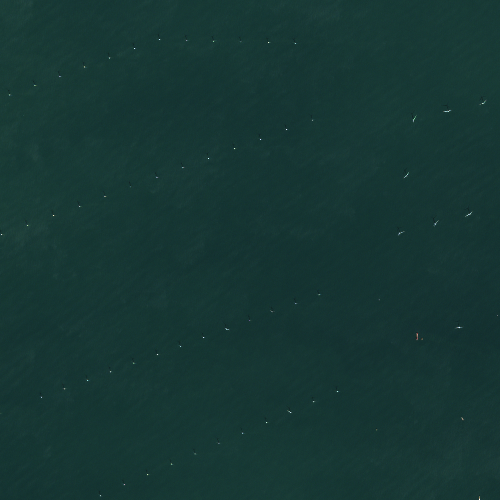

CPU times: user 9.98 ms, sys: 9.57 ms, total: 19.6 ms
Wall time: 514 ms


In [14]:
%%time
image_name = '2015411785-6-6.tiff'
htmlDf = sedona.sql(f"""SELECT RS_AsImage(outdb_raster, 500), name FROM df_raster_input WHERE name = '{image_name}' """)
SedonaUtils.display_image(htmlDf)


</br>
<div style="position: relative; display: flex; flex-direction: column; gap: 20px; 
            font-family: Arial, sans-serif; line-height: 1.6; max-width: 90%; 
            margin: auto; padding: 30px; color: #ffffff; background: #121212; 
            border-radius: 10px;); 
            overflow: hidden;">
    <!-- Title Section -->
    <div style="position: relative; z-index: 2; text-align: left;">
        <h2 style="color: #00f5d4;">Review Detections on top of Satellite Imagery</h2>
    </div>
    <!-- Main Content -->
    <div style="position: relative; z-index: 2;">
        <p style="font-size: 18px; color: #e0e0e0;">
        We can select one or more of the detected <strong>footprints</strong> from the map above. 
        Run the below statement to randomly select images with positive detections. We'll then plot 
        detections overlayed on these images in an interactive map and static comparison maps. In order to make these plots of 
        detections on the source raster, we first need to select three RGB bands in RGB order. The SATLAS geotiff inputs are a 
        timeseries of 3 RGB images, so we can select the first RGB image bands from our Out DB-raster.
        </p>
    </div>
    <!-- Right Section: AI Icon -->
    <div style="display: flex; justify-content: flex-end; position: relative; z-index: 2; margin-top: 10px;">
    </div>
</div>
</br>

In [17]:
from wherobots.inference.plot.detections import *

Too many detections to plot (26). Filter the DataFrame first to no more than 10 unique outdb_rasters if you want to plot specific samples. Randomly sampling 3 records to plot.


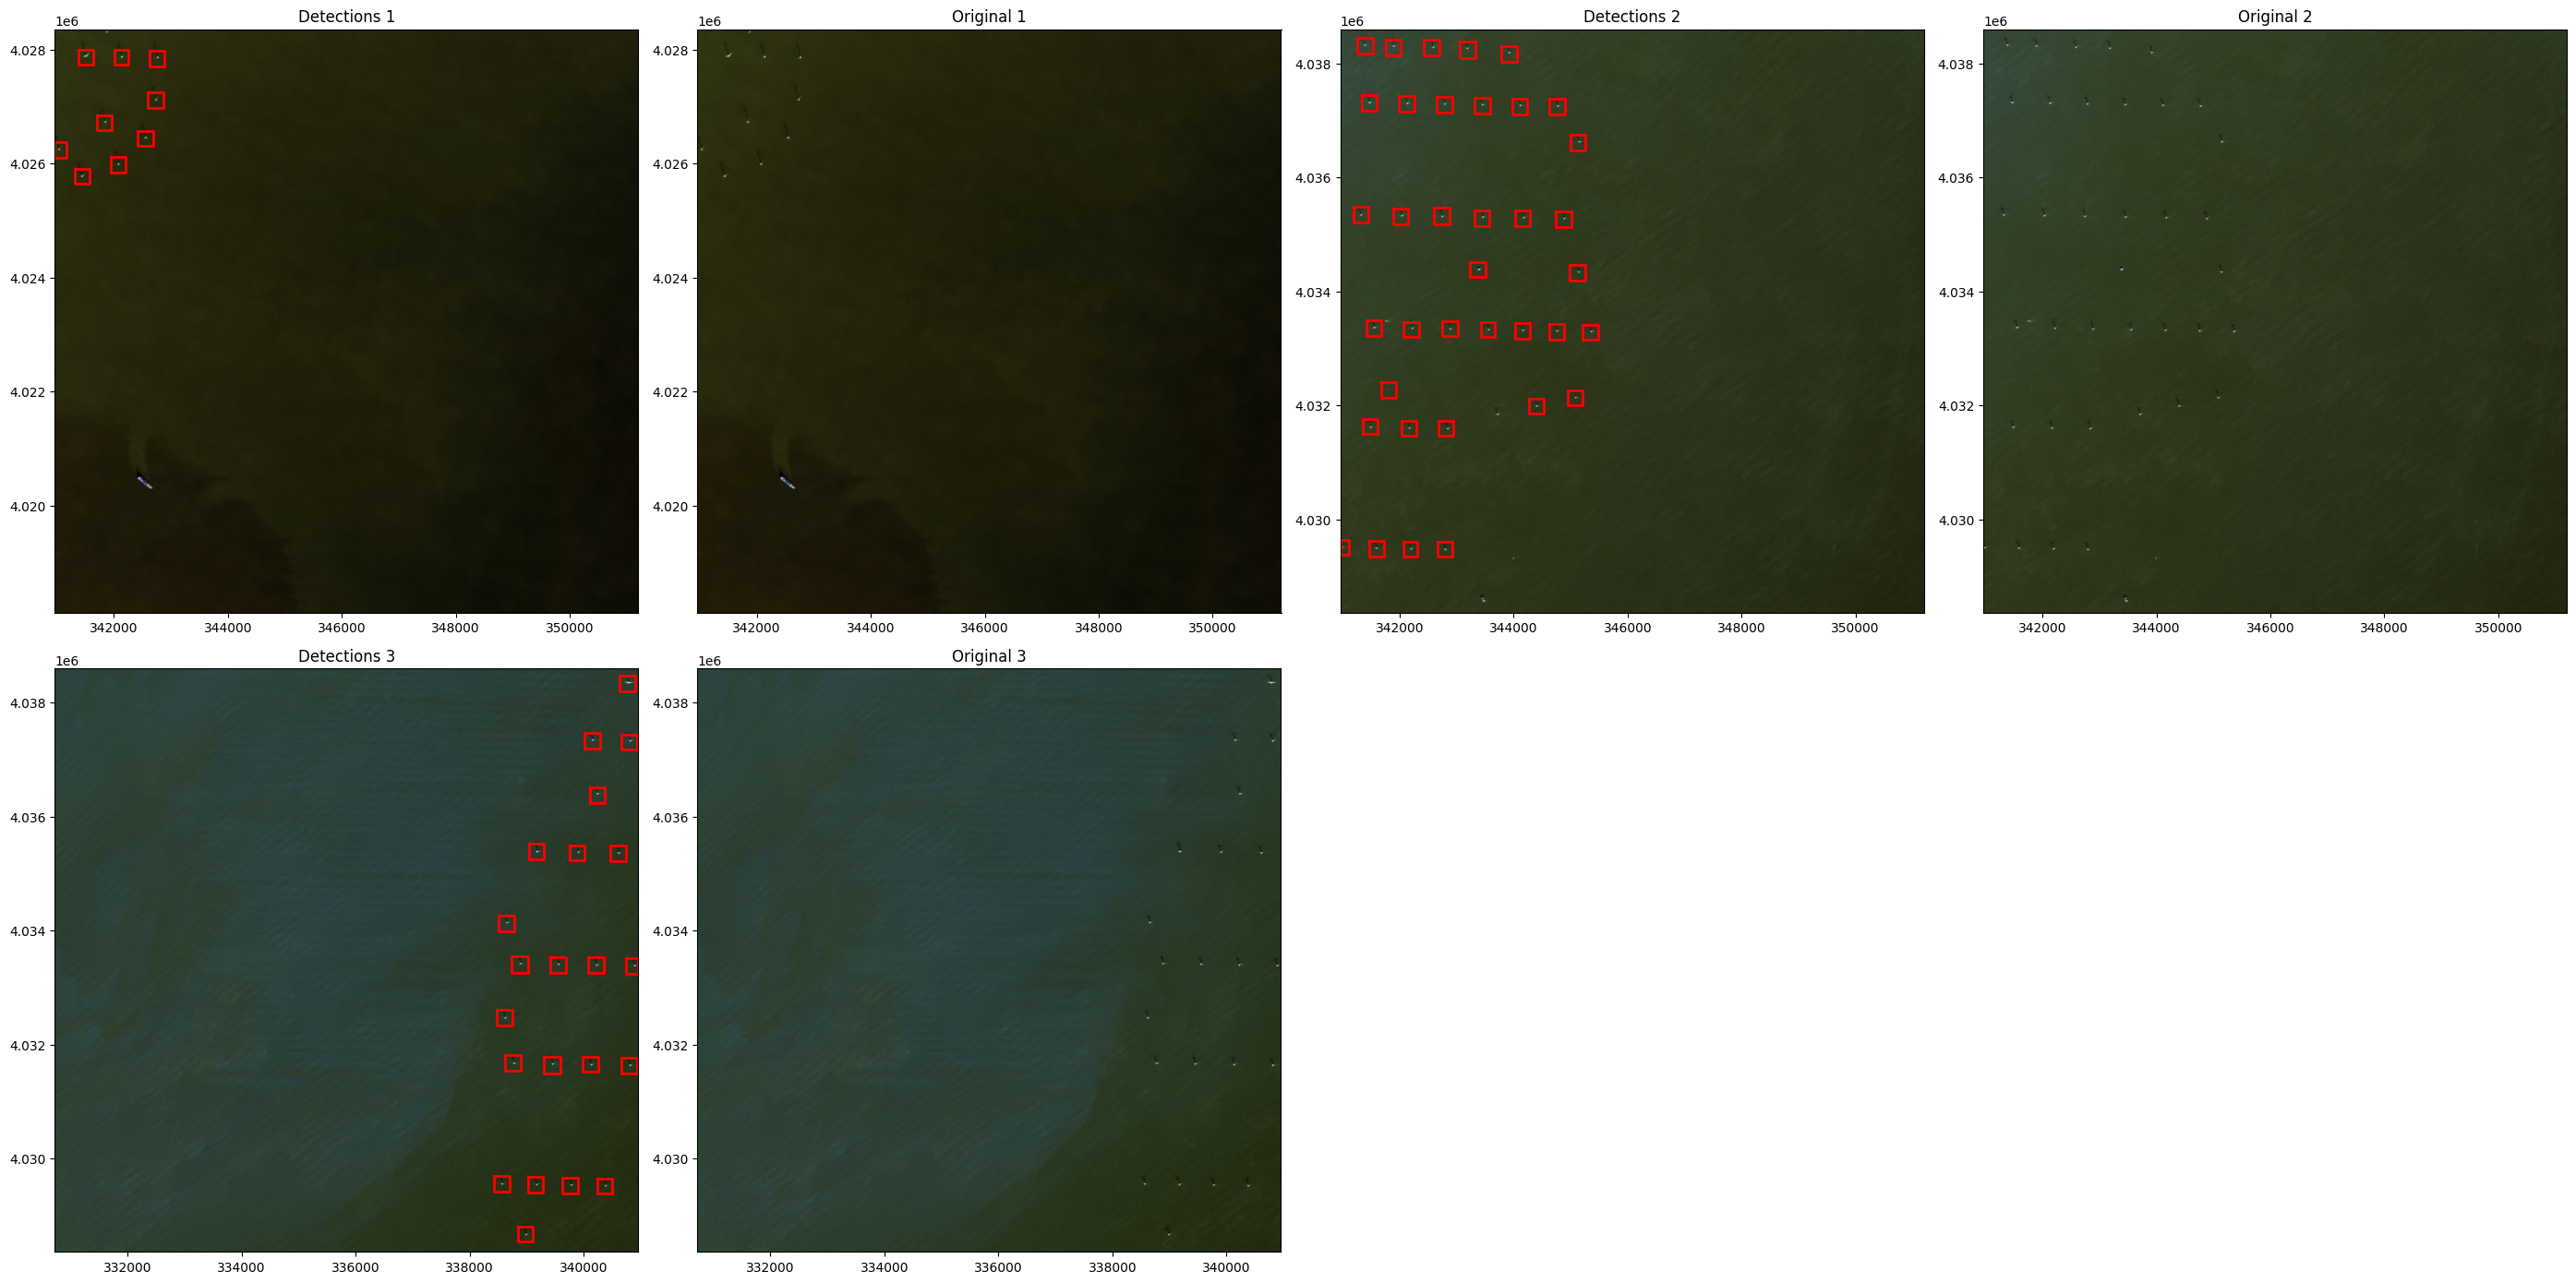

In [18]:
show_detections(filtered_predictions)

In [19]:
show_interactive_detections(filtered_predictions)

Too many detections to plot (26). Filter the DataFrame first to no more than 10 unique outdb_rasters if you want to plot specific samples. Randomly sampling 3 records to plot.


Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

### wherobots.inference Python API

If you prefer python, wherobots.inference offers a module for registering the SQL inference functions as python functions. Below we run the same inference as before with `RS_DETECT_BBOXES`.

In [ ]:
from wherobots.inference.engine.register import create_object_detection_udfs
from pyspark.sql.functions import col
rs_detect, rs_threshold_geoms =  create_object_detection_udfs(batch_size = 10, sedona=sedona)
df = df_raster_input.withColumn("detect_result", rs_detect(model_id, col("outdb_raster"))).select(
                               "outdb_raster",
                               col("detect_result.bboxes_wkt").alias("bboxes_wkt"),
                               col("detect_result.confidence_scores").alias("confidence_scores"),
                               col("detect_result.labels").alias("labels")
                           )
df.show()